# Simulation of 11-3.9um brightness temperature difference

### Setup

**Libraries used:**

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import pandas as pd
import matplotlib.colors as mcolors
import cartopy.feature as feature

**Retrieve GFS data:**

In [2]:
date_str = "20240620"

In [3]:
gfs_file = 'model_data/gfs_'+date_str
gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

skipping variable: paramId==228164 shortName='tcc'
Traceback (most recent call last):
  File "/Applications/anaconda3/envs/FLC_paper/lib/python3.12/site-packages/cfgrib/dataset.py", line 725, in build_dataset_components
    dict_merge(variables, coord_vars)
  File "/Applications/anaconda3/envs/FLC_paper/lib/python3.12/site-packages/cfgrib/dataset.py", line 641, in dict_merge
    raise DatasetBuildError(
cfgrib.dataset.DatasetBuildError: key present and new value is different: key='isobaricInhPa' value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,  250.,
        200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,   15.,
         10.,    7.,    5.,    3.,    2.,    1.])) new_value=Variable(dimensions=('isobaricInhPa',), data=array([1000.,  975.,  950.,  925.,  900.,  850.,  800.,  750.,  700.,
        650.,  600.,  550.,  500.,  450.,  400.,  350.,  300.,

**Select region for simulation:**

In [4]:
#--- Georges Bank (zoomed in)
# latitude_north = 42.5
# latitude_south = 37
# longitude_west = -71.5
# longitude_east = -64

#--- Georges Bank
latitude_north = 46
latitude_south = 33
longitude_west = -73
longitude_east = -57

#--- Oaxaca
# latitude_north = 24
# latitude_south = 8
# longitude_west = -109
# longitude_east = -81

#--- Oaxaca (zoomed in)
# latitude_north = 21
# latitude_south = 8
# longitude_west = -105
# longitude_east = -85

#--- North Atlantic
# latitude_north = 61
# latitude_south = 30
# longitude_west = -80
# longitude_east = -25

#--- Global
# latitude_north = 90
# latitude_south = -90
# longitude_west = -360
# longitude_east = 0

#--- Gulf Stream
# latitude_north = 51
# latitude_south = 30
# longitude_west = -80
# longitude_east = -55

region = gfs_ds.sel(latitude=slice(latitude_north, latitude_south), longitude=slice(360+longitude_west, 360+longitude_east))

region_name = "georgesbank"


In [5]:
datetime_str = np.datetime_as_string(region.time.values, unit='h')
datetime_str = datetime_str.replace('T', ' ')+"Z"
print(datetime_str)

2024-06-20 06Z


### Generate optical thickness tables

**Calculate the water vapor mass density for the region:**
* this is described in RadTran Miller presentation notes
* $r_g$ is the mixing ratio of water vapor, averaged between the layers ($p_1$ and $p_2$)
* mass density ($u$) is in kg m-2

$$
u(p_1, p_2) = \frac{1}{g}\int_{p_2}^{p_1} r_g dp
$$

In [6]:
g = 9.807 #m s-2
u = []

for i in range(len(region.isobaricInhPa.values)-1):
    p1 = region.isobaricInhPa.values[i]*100 #kg s-2 m-1
    p2 = region.isobaricInhPa.values[i+1]*100 #kg s-2 m-1
    dp = p1-p2

    r_g = (region.q.values[i] + region.q.values[i+1]) / 2 #kg kg-1

    u.append((1/g)*r_g*dp) #kg m-2

#--- u has dimensions of (hPa, lat, lon)


**Create an optical mass table:**
* The data is 3-dimensional (pressure, latitude, longitude), so the pandas dataframe is no longer the best method
* Instead, we build an x-array to store the optical mass values

In [7]:
optical_mass_da = xr.DataArray(u, dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})
temperature_da = xr.DataArray(region.t[0:-1], dims=('hPa', 'lat', 'lon'),
                    coords={'hPa': region.isobaricInhPa.values[0:-1], 'lat': region.latitude.values, 'lon': region.longitude.values})


optical_mass_ds = xr.Dataset({'u': optical_mass_da,
                              'T': temperature_da})

**Open the mass extinction look-up tables:**
* made in water_vapor_abs.ipynb

In [8]:
mass_ext_df_13 = pd.read_pickle('tables/mass_ext_band13')
mass_ext_df_14 = pd.read_pickle('tables/mass_ext_band14')
mass_ext_df_07 = pd.read_pickle('tables/mass_ext_band07')

**Create the optical thickness table (optical mass * mass extinction):**
* using the mass extinction look-up tables (HITRAN-driven)
* using the optical mass table (GFS-driven)

In [9]:
import time

In [10]:
#--- Ran through chatGPT, asked the algorithm to make more efficient
#------ Takes 30 minutes for global run

start_time = time.time()

pressure_profile = optical_mass_ds.hPa[:21].values
lat_len = len(optical_mass_ds.lat)
lon_len = len(optical_mass_ds.lon)

# Pre-allocate arrays
optical_thickness_07 = np.zeros([len(pressure_profile), lat_len, lon_len])
optical_thickness_13 = np.zeros([len(pressure_profile), lat_len, lon_len])
optical_thickness_14 = np.zeros([len(pressure_profile), lat_len, lon_len])

# Extract the relevant slices once
temperatures = optical_mass_ds['T'].isel(hPa=slice(0, 21)).values
optical_masses = optical_mass_ds['u'].isel(hPa=slice(0, 21)).values

# Pre-calculate nearest temperature and pressure indices for all bands
nearest_temp_indices_07 = np.argmin((mass_ext_df_07.index.values[:, None] - temperatures.flatten())**2, axis=0)
nearest_pressure_indices_07 = np.argmin((mass_ext_df_07.columns.values[:, None] - pressure_profile)**2, axis=0)

nearest_temp_indices_13 = np.argmin((mass_ext_df_13.index.values[:, None] - temperatures.flatten())**2, axis=0)
nearest_pressure_indices_13 = np.argmin((mass_ext_df_13.columns.values[:, None] - pressure_profile)**2, axis=0)

nearest_temp_indices_14 = np.argmin((mass_ext_df_14.index.values[:, None] - temperatures.flatten())**2, axis=0)
nearest_pressure_indices_14 = np.argmin((mass_ext_df_14.columns.values[:, None] - pressure_profile)**2, axis=0)

# Reshape indices to match the dimensions of temperatures
nearest_temp_indices_07 = nearest_temp_indices_07.reshape((len(pressure_profile), lat_len, lon_len))
nearest_pressure_indices_07 = nearest_pressure_indices_07.reshape(len(pressure_profile))

nearest_temp_indices_13 = nearest_temp_indices_13.reshape((len(pressure_profile), lat_len, lon_len))
nearest_pressure_indices_13 = nearest_pressure_indices_13.reshape(len(pressure_profile))

nearest_temp_indices_14 = nearest_temp_indices_14.reshape((len(pressure_profile), lat_len, lon_len))
nearest_pressure_indices_14 = nearest_pressure_indices_14.reshape(len(pressure_profile))

setup_time = time.time() - start_time
print(f"Setup time: {setup_time:.2f} seconds")

start_time = time.time()

# Iterate through the grid points
#--- Using the full, most accurate pressure profile
#for z in range(len(pressure_profile[:12])):
#--- Only doing up to 550hPa, in order to speed things up
for z in range(len(pressure_profile[:12])):

    start_inner_time = time.time()  # Start timing the outer loop
    print(f"Processing pressure_profile[{z}] = {pressure_profile[z]}")
    for y in range(lat_len):
        for x in range(lon_len):            
            optical_mass_value = optical_masses[z, y, x]

            # Lookup the mass extinction values using pre-calculated indices
            mass_ext_value_07 = mass_ext_df_07.iloc[nearest_temp_indices_07[z, y, x], nearest_pressure_indices_07[z]]
            optical_thickness_07[z, y, x] = optical_mass_value * mass_ext_value_07

            mass_ext_value_13 = mass_ext_df_13.iloc[nearest_temp_indices_13[z, y, x], nearest_pressure_indices_13[z]]
            optical_thickness_13[z, y, x] = optical_mass_value * mass_ext_value_13

            mass_ext_value_14 = mass_ext_df_14.iloc[nearest_temp_indices_14[z, y, x], nearest_pressure_indices_14[z]]
            optical_thickness_14[z, y, x] = optical_mass_value * mass_ext_value_14
            
        
    
    inner_time = time.time() - start_inner_time
    print(f"Outer loop (z={z}) time: {inner_time:.5f} seconds")

loop_time = time.time() - start_time
print(f"Total loop time: {loop_time:.2f} seconds")

print(np.shape(optical_thickness_07))



Setup time: 0.66 seconds
Processing pressure_profile[0] = 1000.0
Outer loop (z=0) time: 0.24199 seconds
Processing pressure_profile[1] = 975.0
Outer loop (z=1) time: 0.24854 seconds
Processing pressure_profile[2] = 950.0
Outer loop (z=2) time: 0.24625 seconds
Processing pressure_profile[3] = 925.0
Outer loop (z=3) time: 0.25015 seconds
Processing pressure_profile[4] = 900.0
Outer loop (z=4) time: 0.25861 seconds
Processing pressure_profile[5] = 850.0
Outer loop (z=5) time: 0.24967 seconds
Processing pressure_profile[6] = 800.0
Outer loop (z=6) time: 0.24038 seconds
Processing pressure_profile[7] = 750.0
Outer loop (z=7) time: 0.25933 seconds
Processing pressure_profile[8] = 700.0
Outer loop (z=8) time: 0.29597 seconds
Processing pressure_profile[9] = 650.0
Outer loop (z=9) time: 0.24696 seconds
Processing pressure_profile[10] = 600.0
Outer loop (z=10) time: 0.23945 seconds
Processing pressure_profile[11] = 550.0
Outer loop (z=11) time: 0.23964 seconds
Total loop time: 3.02 seconds
(21,

### Build functions for radiance and brightness temperature

**Build the functions for expected radiance and brightness temperature:**
* functions are similar to those in expected_radiance.ipynb, but for a 3d field

**Calculating the blackbody radiance ($B_\lambda^\uparrow$):**

$$
B_\lambda (T) = \frac{2hc^2}{\lambda^5 [e^{hc/k\lambda T} -1]}
$$

* $h$ is the Planck constant, $6.626 \times 10^{-34} \text{ J s}$
* $c$ is the speed of light, $3 \times 10^{8} \text{ m s}^{-1}$
* $k$ is the Boltzmann constant, $1.380 \times 10^{-23} \text{ J K}^{-1}$

In [11]:
def blackbody_radiance(T, wl):
    h = 6.626e-34
    c = 3e8
    k = 1.380e-23
    B = (2*h*c**2)/(wl**5 * (np.exp((h*c)/(k*wl*T))-1))
    return B

**Calculating expected radiance ($I_\lambda$):**

$$
I_\lambda^\uparrow (\infty, \mu)= B_\lambda^\uparrow (T_\text{sfc}) e^{-\tau^*_\lambda / \mu} + \sum_{i=0}^N B_\lambda^\uparrow (z_i) \frac{d\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)}{dz} \Delta z_i
$$

* $B_\lambda^\uparrow (T_\text{sfc})$ is the blackbody radiance from the surface temperature
* $\tau^*$ is optical thickness of atmosphere
* $\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)$ is transmittance upward from height level ($z_i$) to TOA ($\infty$) with viewing angle ($\mu$)

**Calculating radiance from surface:**

Equation for expected radiance ($I_\lambda^\uparrow$) from the surface through the TOA. Includes the total absorption by the optical thickness, but not the individual absorption/emission of each layer. 

$$
B_\lambda^\uparrow (T_\text{sfc}) e^{-\tau^*_\lambda / \mu}
$$

In [12]:
def I_sfc(T_sfc, optical_thickness, wl):

    #--- viewing angle of the satellite
    mu = 1

    #--- numpy 3D array sum over the pressure axis
    tau_star = np.sum(optical_thickness, axis=0)
    
    #--- expected radiance calculation
    I_sfc = blackbody_radiance(T_sfc, wl)*np.exp(-tau_star/mu)

    return I_sfc

**Calculating radiance from atmosphere:**

Equation for the expected radiance ($I_\lambda^\uparrow$) from the absorption/emission of each atmospheric layer. 

$$
\sum_{i=0}^N B_\lambda^\uparrow (z_i) \frac{d\mathfrak{T}_\lambda^\uparrow (z_i, \infty, \mu)}{dz} \Delta z_i
$$

In [13]:
def I_atm(optical_thickness, optical_mass_ds, wl):

    #--- Number of pressure levels for integration
    p_len = np.shape(optical_thickness)[0] - 1

    I_levels = []
    mu = 1

    for i in range(p_len):

        #---Temperature and blackbody radiance at current level
        T = optical_mass_ds.isel(hPa=i)['T']
        B = blackbody_radiance(T, wl)

        tau_above = np.sum(optical_thickness[i+1:], axis=0)
        tau_level = np.sum(optical_thickness[i:], axis=0)

        press_levels = optical_mass_ds['hPa'][:21].values
        dp = press_levels[i+1] - press_levels[i]

        dT_dp = ((np.exp(-tau_above/mu)) - (np.exp(-tau_level/mu))) / dp
        
        #---Radiance from each atmospheric level
        I_level = B*dT_dp*dp
        I_levels.append(I_level)

    #---Summing the radiance to get the total at TOA
    I_atm = np.sum(I_levels, axis=0)
    return I_atm

**Calculating the brightness temperature:**

Calculating the brightness temperature ($T_{b,\lambda}$) from the expected radiance: 

$$
T_{b,\lambda} = \frac{hc}{k\lambda \text{ ln}\left[1+\frac{2hc^2}{I \lambda^5}\right]}
$$

In [14]:
def brightness_temperature(I, wl):
    h = 6.626e-34
    c = 3e8
    k = 1.380e-23
    Tb = (h*c)/(k*wl * np.log(1 + ((2*h*c**2)/(I*wl**5))))
    return Tb

### Run brightness temperature for specific wavelength (set here)

**Setting wavelength of interest:**

In [15]:
wl = 3.9e-6
optical_thickness = optical_thickness_07
wl_str = str(wl*1e6).replace(".", "_")

**Brightness temperature using NOAA SST as surface:**

In [16]:
sst_file = "sst_data/sst_"+date_str

sst_ds = xr.open_dataset(sst_file, engine='netcdf4')
sst_ds =  sst_ds.squeeze()

#--- Convert from C to K
sst_ds.sst.values = sst_ds.sst.values+273.15

In [17]:
#--- Fill the nan values with zero
sst_ds = sst_ds.sst.fillna(0)

Crop SST data down to the same range as the model data: 
* The latitude slice also flips the dataset, so that the north/south orientation is correct

In [18]:
sst_ds = sst_ds.sel(lat=slice(latitude_north,latitude_south,-1), lon=slice(longitude_west+360,longitude_east+360))

Match the SST shape to the GFS shape:

In [19]:
print("Shape of SST array:", np.shape(sst_ds))
print("Shape of optical thickness array:", np.shape(optical_thickness))

#--- This copies two edges out by one more row, to fit the dimensions of the model data
#sst_padded = np.pad(sst_ds, ((0, 1), (0, 1)), mode='edge')

#--- Global mapping causes border issue, this is a workaround
sst_padded = sst_ds
if np.shape(sst_ds)[0] != np.shape(optical_thickness)[1]:
    sst_padded = np.pad(sst_ds, ((1, 0), (0, 0)), mode='edge')
if np.shape(sst_padded)[1] != np.shape(optical_thickness)[2]:
    sst_padded = np.pad(sst_padded, ((0, 0), (0, 1)), mode='edge')

print("Shape of SST padded array:", np.shape(sst_padded))

Shape of SST array: (52, 64)
Shape of optical thickness array: (21, 53, 65)
Shape of SST padded array: (53, 65)


In [20]:
#---Setting longitude values back to -180 to 180
#------Maybe not necessary

# lons = region.longitude.values-180

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_3886/3070869146.py:5: RuntimeWarning: divide by zero encountered in divide
  B = (2*h*c**2)/(wl**5 * (np.exp((h*c)/(k*wl*T))-1))


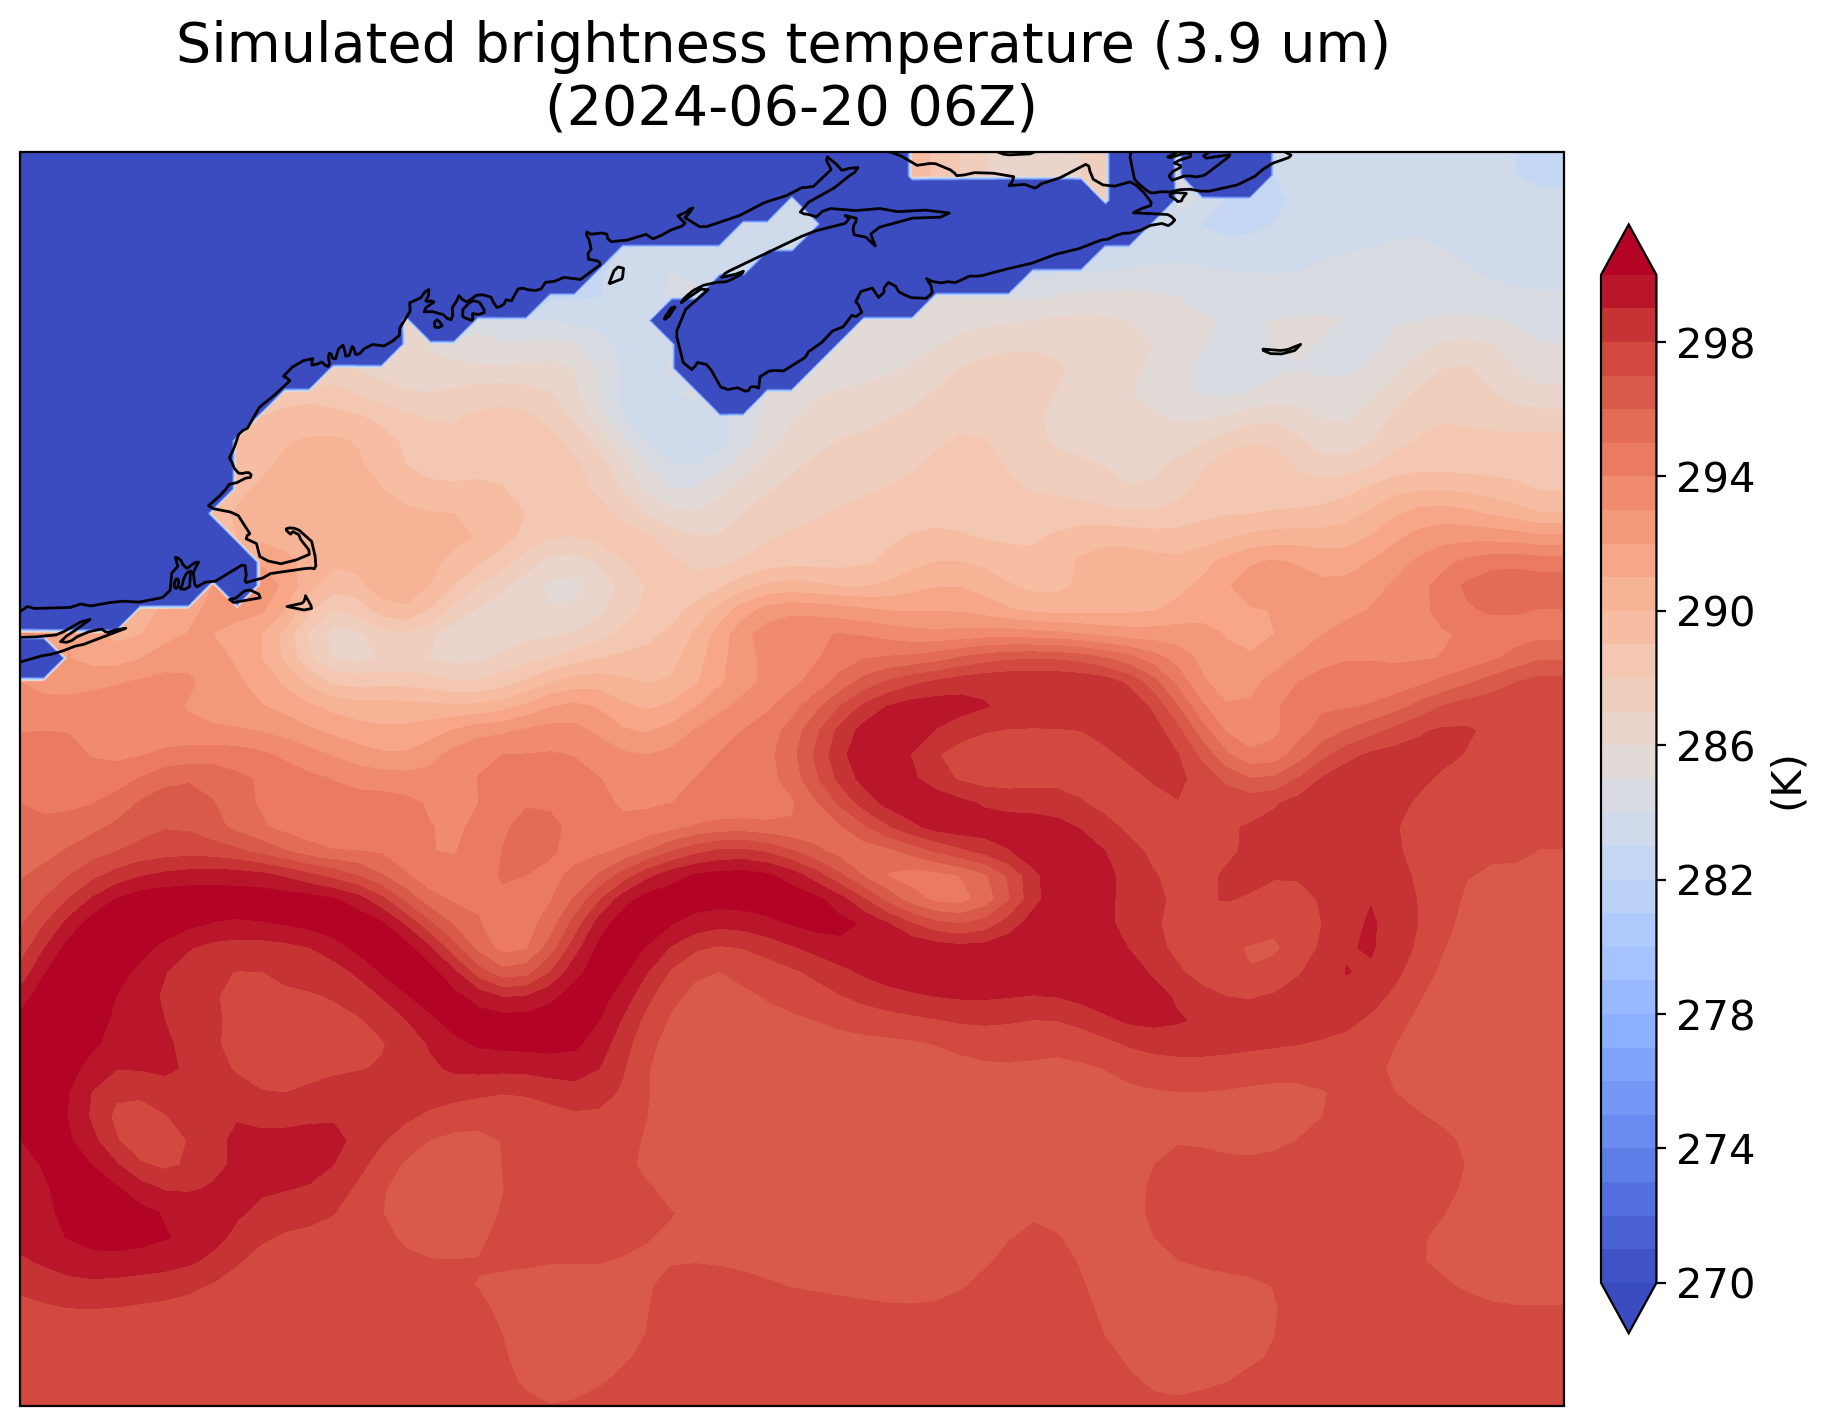

In [21]:
I_tot = I_sfc(sst_padded, optical_thickness, wl) + I_atm(optical_thickness, optical_mass_ds, wl)

Tb = brightness_temperature(I_tot, wl)

projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.coolwarm
levels = np.linspace(270, 300, 31)

c=ax.contourf(region.longitude, region.latitude, Tb, cmap=cmap, extend='both', levels=levels)

clb = plt.colorbar(c, shrink=0.6, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

#--- Remove for global mapping
#ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Simulated brightness temperature ("+ str(round(wl*1e6, 1)) +" um) \n("+datetime_str+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.set_dpi(200)
#fig.savefig("/Users/jturner/Downloads/brightness_temperature_sst_"+wl_str+"_"+date_str, dpi=200, bbox_inches='tight')

### Calculate the brightness temperature difference

**Calculating the brightness temperature difference:**

In [22]:
first_wl = 11.2e-6
first_optical_thickness = optical_thickness_14
first_wl_str = str(first_wl*1e6).replace(".", "_")

second_wl = 3.9e-6
second_optical_thickness = optical_thickness_07
second_wl_str = str(second_wl*1e6).replace(".", "_")

In [23]:
first_I_tot = I_sfc(sst_padded, first_optical_thickness, first_wl) + I_atm(first_optical_thickness, optical_mass_ds, first_wl)
second_I_tot = I_sfc(sst_padded, second_optical_thickness, second_wl) + I_atm(second_optical_thickness, optical_mass_ds, second_wl)

BTD = brightness_temperature(first_I_tot, first_wl) - brightness_temperature(second_I_tot, second_wl)

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_3886/3070869146.py:5: RuntimeWarning: divide by zero encountered in divide
  B = (2*h*c**2)/(wl**5 * (np.exp((h*c)/(k*wl*T))-1))


In [25]:
#--- Replace surface values with NaN (>20)
BTD = np.where(BTD > 20, np.nan, BTD)

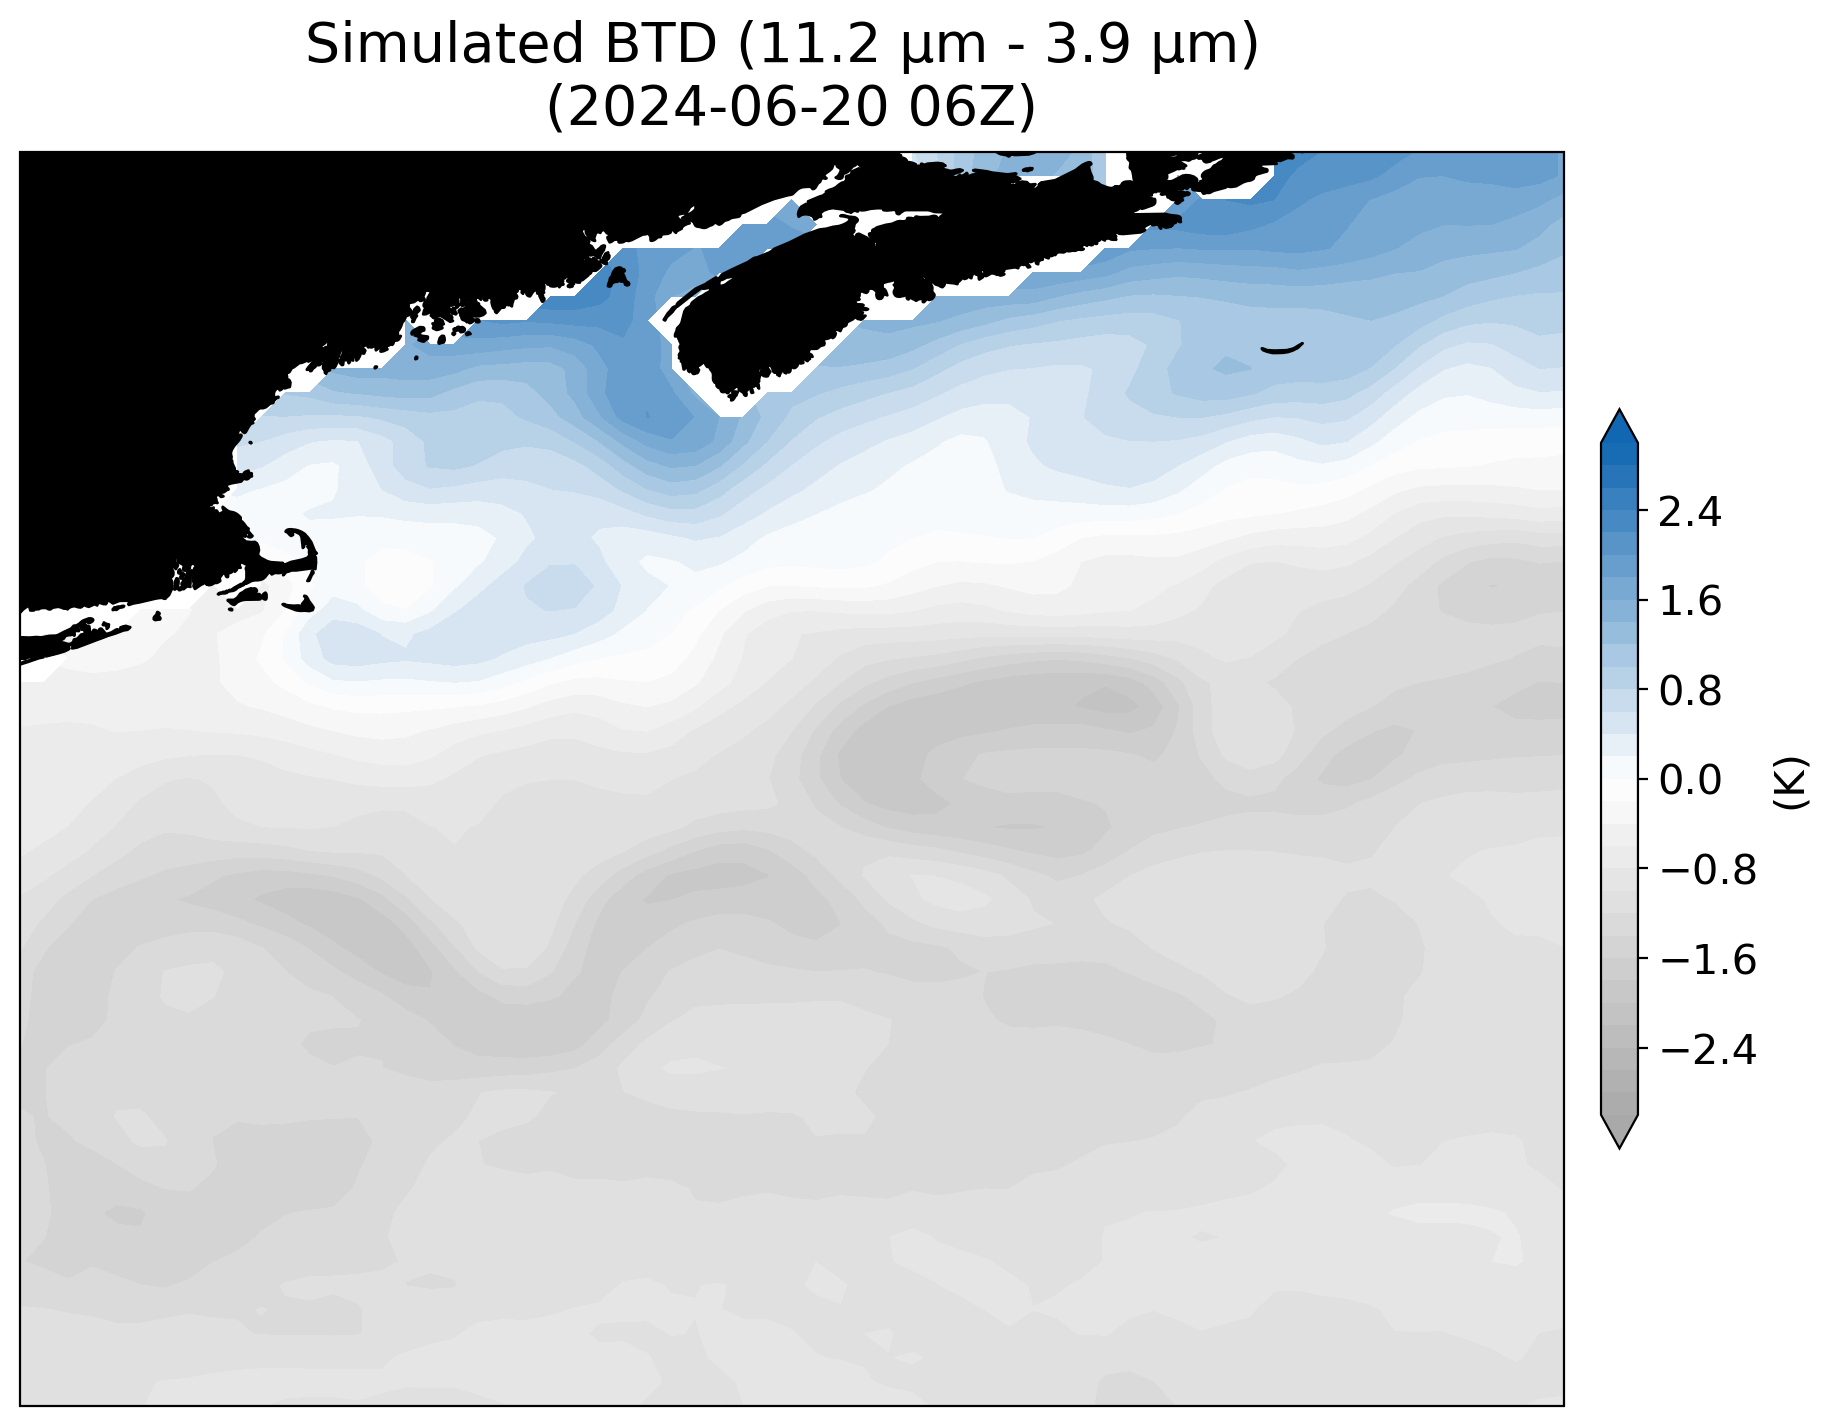

In [ ]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

#---Custom colorbar
from matplotlib.colors import LinearSegmentedColormap
colors = [(0, '#A9A9A9'), (0.5, 'white'), (1, '#1167b1')]  # +3 = blueish teal, 0 = white, -3 = grey
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)


#---Local max and min, taking into account the zeroes from the NAN region (land)
max_BTD = max([value for row in BTD for value in row if value > -20], default=None)
min_BTD = min([value for row in BTD for value in row if value > -20], default=None)

#levels = np.linspace(min_BTD, max_BTD, 31)
levels = np.linspace(-3, 3, 31)

#--- Original local mapping
c=ax.contourf(region.longitude, region.latitude, BTD, cmap=cmap, extend='both', levels=levels)

#--- Adding point for checking BTD
# latitude = 41
# longitude = -68
#plt.scatter(longitude, latitude, c='blue', edgecolors='white', s=40)

clb = plt.colorbar(c, shrink=0.4, pad=0.02, ax=ax)
clb.ax.tick_params(labelsize=15)
clb.set_label('(K)', fontsize=15)

#--- Remove for global mapping
#ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Simulated BTD ("+ str(round(first_wl*1e6, 1)) + " μm - " + str(round(second_wl*1e6, 1)) +" μm) \n("+datetime_str+")", fontsize=20, pad=10)

#--- Land in tan
ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='tan')

#--- Land in black
#ax.add_feature(feature.LAND, zorder=100, edgecolor='#000', facecolor='#000')

#--- Adding lakes
#ax.add_feature(feature.LAKES, zorder=100, edgecolor='#000', facecolor='none')

fig.set_dpi(200)
#fig.savefig("composite/images/"+region_name+"_"+date_str, dpi=200, bbox_inches='tight')

*Save the FLCI data:*

In [ ]:
btd_ds = xr.Dataset(
    {
        "BTD": (["latitude", "longitude"], BTD)
    },
    coords={
        "longitude": region.longitude.values,
        "latitude": region.latitude.values
    }
)

#--- Save as NetCDF
#btd_ds.to_netcdf("btd_data/"+region_name+"_"+date_str+".nc")

In [ ]:
#--- Save as a netCDF
#------ plot in FLCI_composite.ipynb

#--- Build a new xarray
btd_ds = xr.Dataset(
    {
        "BTD": (["latitude", "longitude"], BTD)
    },
    coords={
        "latitude": region.latitude,
        "longitude": region.longitude
    }
)

#--- Do this for all the global runs
if (longitude_west == -360) and (longitude_east == 0): 
    btd_ds.to_netcdf("composite/"+region_name+"/"+region_name+"_"+date_str+".nc")
else: print("Not saved")

Not saved


### Wind speed and direction

/var/folders/s0/p4kwg0r17s59t6f4g9btngzw0000gn/T/ipykernel_11658/2229480480.py:28: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


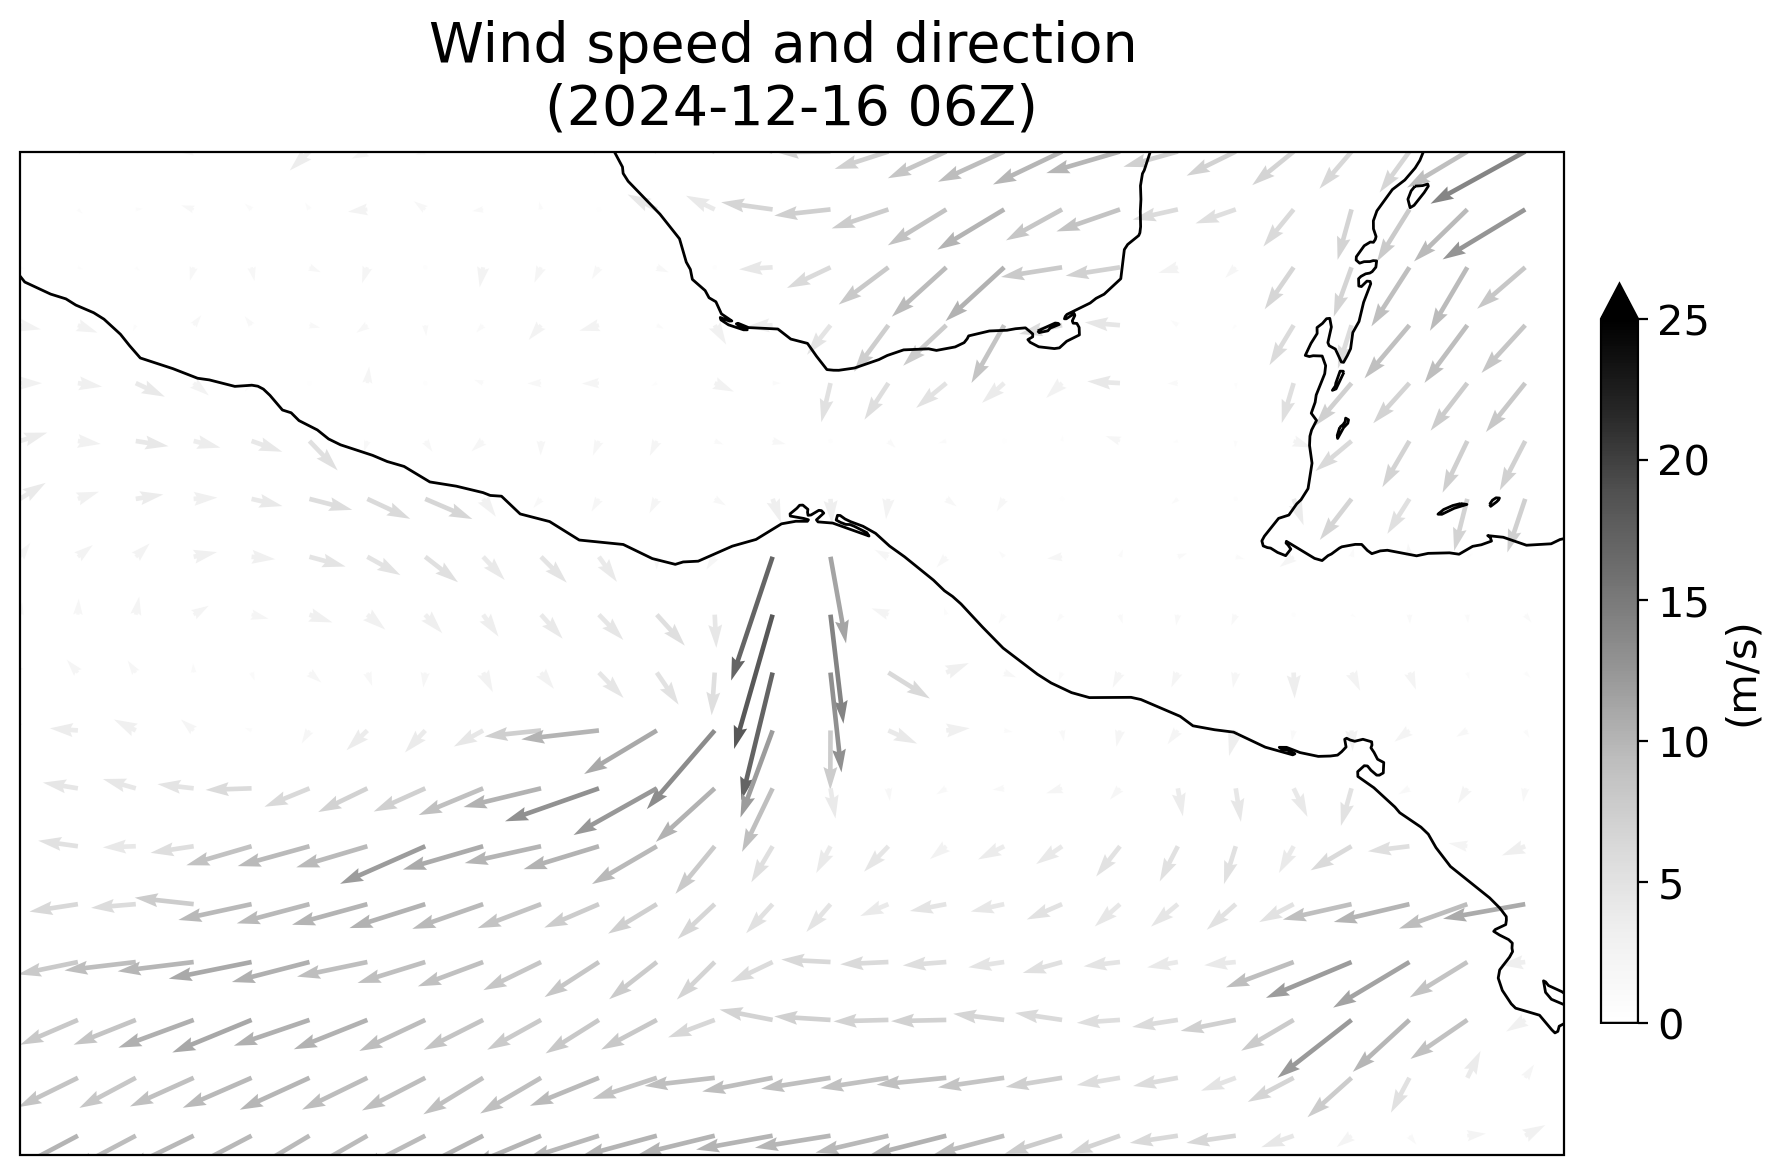

In [ ]:
projection=ccrs.PlateCarree(central_longitude=0)
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})


X, Y = np.meshgrid(region['longitude'], region['latitude'])
X = X[0:len(region['latitude']):3,0:len(region['longitude']):3]
Y = Y[0:len(region['latitude']):3,0:len(region['longitude']):3]

U = region['u'][0,:,:].values[0:len(region['latitude']):3,0:len(region['longitude']):3]
V = region['v'][0,:,:].values[0:len(region['latitude']):3,0:len(region['longitude']):3]

arrow_lengths = np.sqrt(U**2 + V**2)
colors = plt.get_cmap('Greys')
norm = mcolors.Normalize(vmin=0, vmax=25) 

q = ax.quiver(X, Y, U, V, arrow_lengths, cmap=colors, norm=norm, transform=ccrs.PlateCarree(), width=0.003, scale_units='xy', scale=10)

clb = plt.colorbar(q, shrink=0.4, pad=0.02, ax=ax, extend='max')
clb.ax.tick_params(labelsize=15)
clb.set_label('(m/s)', fontsize=15)

ax.set_extent([longitude_west, longitude_east, latitude_south, latitude_north], crs=ccrs.PlateCarree())

ax.set_title("Wind speed and direction \n("+datetime_str+")", fontsize=20, pad=10)
ax.coastlines(resolution='50m', color='black', linewidth=1)

fig.set_dpi(200)
fig.show()